# MicroFit
A small, pure Python library for fitting MicroBooNE data.

## Prerequisites

Follow these instructions to set up the Conda environment: https://github.com/ubneutrinos/searchingfornues/wiki/CONDA-setup-for-python3 . Some additional packages may be needed that can be installed with `conda install` or `pip install` as needed.
You will need a file `localSettings.py` in the root directory of this repository that defines the root directory where all the data lives that at least contains:
```python
ntuple_path = '/path/to/ntuples'
```

Further, you will need to make sure that all the data files you want to load are listed in `data_paths.yml`.

## Loading Data
You can load any number of runs with any selection of truth-filtered data sets using the `load_runs` function defined in `data_loading.py`. With caching enabled, individual dataframes will be stored to disk for faster loading in the future. The first variable returned by the function is a dictionary where the keys are the names of the datasets and the values are the corresponding dataframes. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os 
from data_loading import load_runs

RUN = ["1"]  # this can be a list of several runs, i.e. [1,2,3]
rundata, mc_weights, data_pot = load_runs(
    RUN,
    data="bnb",  # which data to load
    # truth_filtered_sets=["nue", "drt", "nc_pi0", "cc_pi0", "cc_nopi", "cc_cpi", "nc_nopi", "nc_cpi"],
    # Which truth-filtered MC sets to load in addition to the main MC set. At least nu_e and dirt
    # are highly recommended because the statistics at the final level of the selection are very low.
    truth_filtered_sets=["nue", "drt"],
    # Choose which additional variables to load. Which ones are required may depend on the selection
    # you wish to apply.
    loadpi0variables=True,
    loadshowervariables=True,
    loadrecoveryvars=True,
    loadsystematics=True,
    # Load the nu_e set one more time with the LEE weights applied
    load_lee=True,
    # With the cache enabled, by default the loaded dataframes will be stored as HDF5 files
    # in the 'cached_dataframes' folder. This will speed up subsequent loading of the same data.
    enable_cache=True,
    # Since this is Open Data, we are allowed to unblind the data. By default, the data is blinded.
    blinded=False,
)

Loading run 1


In [3]:
rundata.keys()

dict_keys(['data', 'ext', 'mc', 'nue', 'drt', 'lee'])

In [4]:
rundata["mc"]

,shr_tkfit_npointsvalid,knobCCMECup,matched_E,shr_bkt_pdg,pi0truth_gamma1_ypos,shr_tkfit_gap10_dedx_U,shr_hits_2nd,nneutron,true_nu_vtx_sce_z,shr_tkfit_dedx_V,...,dy,dz,dr,paper_category,paper_category_xsec,paper_category_numu,category_1e1p,dataset,weights,weights_no_tune
entry,,,,,,,,,,,,,,,,,,,,,
0,6.400000e+01,1.00000,0.137951,0,0.000000,3.692302e+00,0,1,350.963531,3.625594e+00,...,-0.155454,-0.143097,0.211768,2,2,2,2,mc,0.130186,0.130186
1,7.800000e+01,1.00000,0.522941,-211,0.000000,1.851375e+00,0,0,327.012787,1.923348e+00,...,0.090927,0.135254,0.170766,2,2,2,12,mc,0.130186,0.130186
2,5.600000e+01,1.00000,0.262988,13,15.002559,-3.402823e+38,0,0,284.053894,5.378916e+00,...,-0.155703,-0.838928,0.853762,31,31,2,12,mc,0.130186,0.130186
3,1.180000e+02,1.00000,0.544794,22,17.744255,7.583195e+00,0,13,84.939651,4.426060e+00,...,0.597797,0.057831,0.681040,31,31,2,21,mc,0.130186,0.130186
4,2.147484e+09,1.00000,0.305635,2212,0.000000,-3.402823e+38,35,9,493.408661,-3.402823e+38,...,1.125980,-1.834167,2.179828,2,2,2,13,mc,0.130186,0.130186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31449,1.110000e+02,1.00000,0.307300,22,-92.090500,3.618627e+00,0,0,420.302094,1.604985e+00,...,-0.203354,0.005127,0.217784,31,31,2,12,mc,0.130186,0.130186
31450,1.240000e+02,1.24172,0.000000,0,0.000000,1.609862e+00,0,0,306.004486,2.621803e+00,...,254.107513,172.795624,308.342957,2,2,2,12,mc,0.161050,0.129699
31451,1.000000e+02,1.00000,0.166483,22,-5.031834,4.044884e+00,0,0,445.345367,4.641893e+00,...,6.810709,1.183167,9.248138,31,31,2,13,mc,0.130186,0.130186


The dataframes have already been concatenated over the runs and are weighted such that the total norm should match that of the data. The weights are stored in the `weights` column. We can use it to make a simple histogram even without the rest of the framework. Also, events for which truth-filtered sets have been loaded are already removed from the "mc" set, so there is no need to worry about double-counting of events. When we plot the stacked histogram of all MC and EXT on top of the data, we should see a good agreement.

['mc', 'nue', 'drt', 'ext']


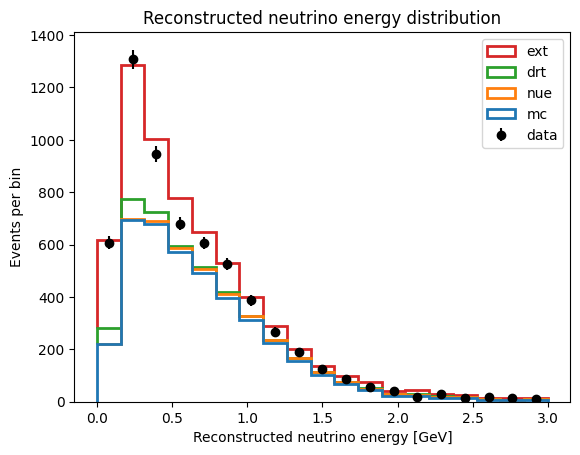

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the distribution of reconstructed neutrino energy (`reco_e`).
# We have to set the binning manually because sometimes a filler value is used
# that is a very large number. To get the total predicted number of events,
# we have to add all MC sets and the EXT data set.

bins = np.linspace(0, 3, 20)
background_keys = list(set(rundata.keys()) - set(["data", "lee"]))
print(background_keys)
plt.hist(
    [rundata[key]["reco_e"] for key in background_keys],
    bins=bins,
    weights=[rundata[key]["weights"] for key in background_keys],
    histtype="step",
    lw=2,
    stacked=True,
    label=[key for key in background_keys],
)
# show data hist on top as points with error bars
data_bin_content, data_bin_edges = np.histogram(
    rundata["data"]["reco_e"], bins=bins, weights=rundata["data"]["weights"]
)
data_bin_errors = np.sqrt(data_bin_content)
data_bin_centers = (data_bin_edges[:-1] + data_bin_edges[1:]) / 2
plt.errorbar(
    data_bin_centers,
    data_bin_content,
    yerr=data_bin_errors,
    fmt="o",
    label="data",
    color="black",
)
plt.legend()
plt.xlabel("Reconstructed neutrino energy [GeV]")
plt.ylabel("Events per bin")
plt.title("Reconstructed neutrino energy distribution")
plt.show()

## The RunHistGenerator

The `RunHistGenerator` class is defined in `histogram.py` and is mainly responsible for making histograms of full runs with annotated event categories. Most importantly, this class also handles the calculation of the systematic uncertainties as a covariance matrix using "multisim" and "unisim" weights.

In [6]:
from microfit.histogram import Binning, Histogram, RunHistGenerator

# The query strings for the selection are defined in the `selections.py` file.
selection = "NPBDT"
preselection = "NP"
# Binnings are defined by the variable to be binned, the number of bins, and the range, and the label.
binning_def = ("reco_e", 10, (0.15, 1.55), r"Reconstructed Energy [GeV]")
binning = Binning.from_config(*binning_def)
binning.label = "NPBDT"  # a unique label to identify the channel later
binning.set_selection(selection, preselection)
# The binning is a class with a defined repr:
binning

Binning(variable='reco_e', bin_edges=array([0.15, 0.29, 0.43, 0.57, 0.71, 0.85, 0.99, 1.13, 1.27, 1.41, 1.55]), label='NPBDT', variable_tex='Reconstructed Energy [GeV]', is_log=False, selection_query='nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained > 0 and nslice == 1 and selected == 1 and shr_energy_tot_cali > 0.07 and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1) and n_tracks_contained > 0 and CosmicIPAll3D > 10. and trkpid < 0.02 and hits_ratio > 0.50 and shrmoliereavg < 9 and subcluster > 4 and trkfit < 0.65 and tksh_distance < 6.0 and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 0.5 and shr_tkfit_dedx_max < 5.5) and tksh_angle > -0.9 and shr_trk_len < 300. and pi0_score > 0.67 and nonpi0_score > 0.70 and n_showers_contained == 1', selection_key='NPBDT', preselection_key='NP', selection_tex='1eNp BDT sel.', select

In [7]:
signal_generator = RunHistGenerator(
    rundata,
    binning,
    data_pot=data_pot,
    # selection=selection,
    # preselection=preselection,
)

The objects returned by the `RunHistGenerator` are of type `Histogram`. This class not only stored bin counts, but also the associated covariance matrices and simplifies arithmatic with histograms. For example, we can add or multiply two histograms together and the covariance will be appropriately propagated automatically. The `Histogram` class also has a `plot` method that can be used to plot the histogram with error bands.

Histogram(binning=Binning(variable='reco_e', bin_edges=array([0.15, 0.29, 0.43, 0.57, 0.71, 0.85, 0.99, 1.13, 1.27, 1.41, 1.55]), label='NPBDT', variable_tex='Reconstructed Energy [GeV]', is_log=False, selection_query=None, selection_key='NPBDT', preselection_key='NP', selection_tex='1eNp BDT sel.', selection_tex_short='1eNp BDT'), bin_counts=[0.64806877 2.30807423 2.85679784 3.01801546 2.1492758  2.8127764
 1.80411964 1.33036657 1.15327039 0.97089849], label=MC+EXT, tex=MC+EXT)

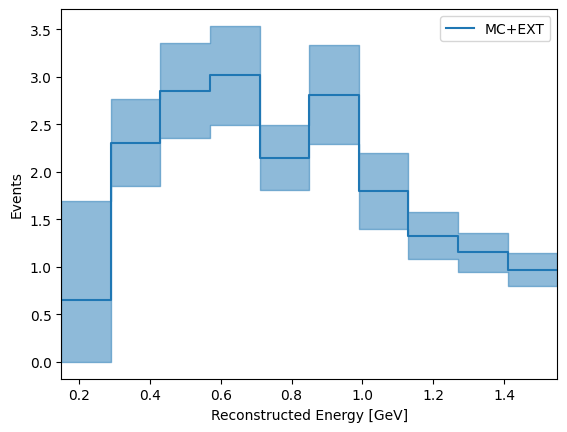

In [8]:
total_prediction = signal_generator.get_total_prediction(include_multisim_errors=True)
# The `Histogram` class also defines a repr that makes a nice plot when run inside a Jupyter notebook:
total_prediction

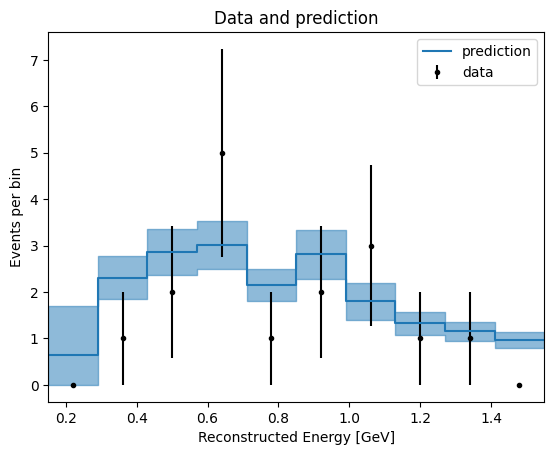

In [9]:
data_hist = signal_generator.get_data_hist()
fig, ax = plt.subplots()
data_hist.draw(ax=ax, label="data", as_errorbars=True)
total_prediction.draw(ax=ax, label="prediction", as_errorbars=False)
ax.legend()
ax.set_xlabel(binning.variable_tex)
ax.set_ylabel("Events per bin")
ax.set_title("Data and prediction")
plt.show()

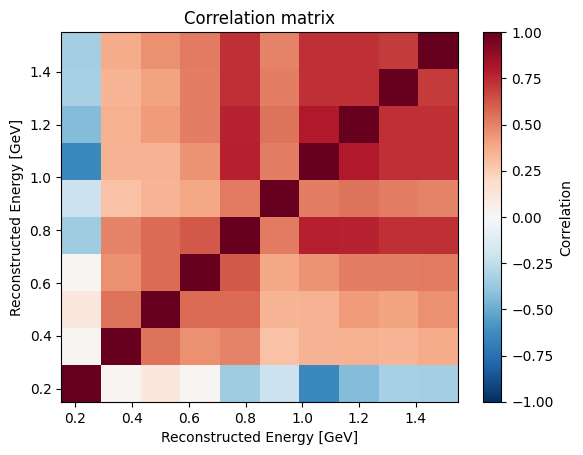

In [10]:
# We can also ask it to draw the covariance matrix
fig, ax = plt.subplots()
total_prediction.draw_covariance_matrix(ax=ax)
plt.show()

Histograms can also be divided to calculate the ratio. The covariance will be correctly propagated. 

/nashome/a/atrettin/PELEE/microfit/statistics.py:447: RuntimeWarning: divide by zero encountered in double_scalars
  Cy[i, i] = y[i] ** 2 * (C1[i, i] / x1[i] ** 2 + C2[i, i] / x2[i] ** 2)
/nashome/a/atrettin/PELEE/microfit/statistics.py:447: RuntimeWarning: invalid value encountered in double_scalars
  Cy[i, i] = y[i] ** 2 * (C1[i, i] / x1[i] ** 2 + C2[i, i] / x2[i] ** 2)
/nashome/a/atrettin/PELEE/microfit/statistics.py:450: RuntimeWarning: invalid value encountered in double_scalars
  Cy[i, j] = y[i] * y[j] * (C1[i, j] / (x1[i] * x1[j]) + C2[i, j] / (x2[i] * x2[j]))


<AxesSubplot:xlabel='Reconstructed Energy [GeV]', ylabel='Events'>

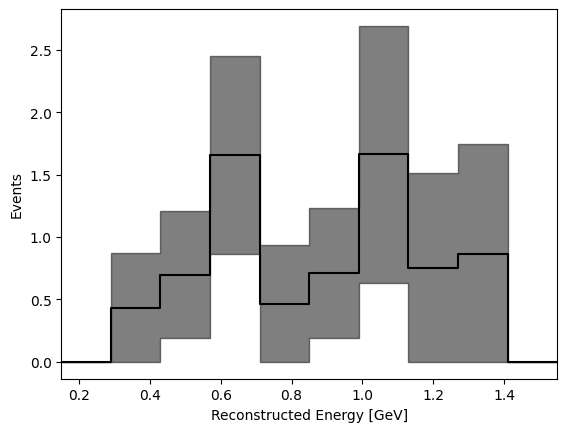

In [11]:
data_mc_ratio = data_hist / total_prediction
fig, ax = plt.subplots()
data_mc_ratio.draw(ax=ax, label="data / prediction", as_errorbars=False)

## The RunHistPlotter

A more convent way to plot the histograms generated by the `RunHistGenerator` is to use the `RunHistPlotter` class defined in `run_plotter.py`.

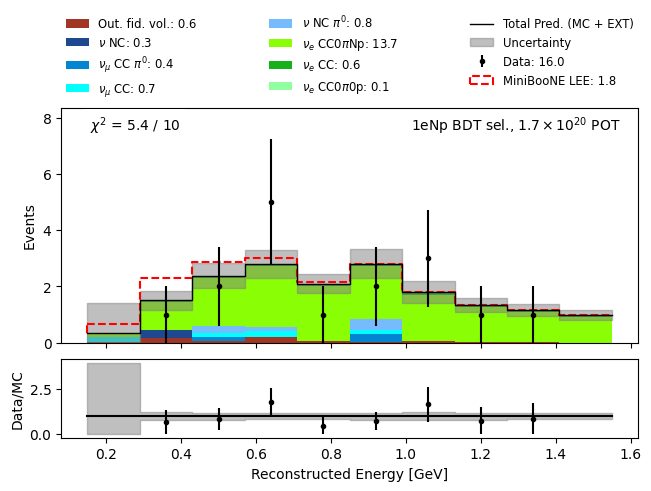

In [12]:
from microfit.run_plotter import RunHistPlotter

plotter = RunHistPlotter(signal_generator)
# The category column can be used to split the prediction into different categories.
# Predefined categories are "category", "paper_category", "paper_category_xsec" and "category_1e1p".
# New categories can be added by adding a corresponding column to the dataframe and then define
# the labels in the file `category_definitions.py`.
ax = plotter.plot(
    category_column="category",
    include_multisim_errors=True,
    add_ext_error_floor=False,
    show_data_mc_ratio=True,
    show_chi_square=True,
)

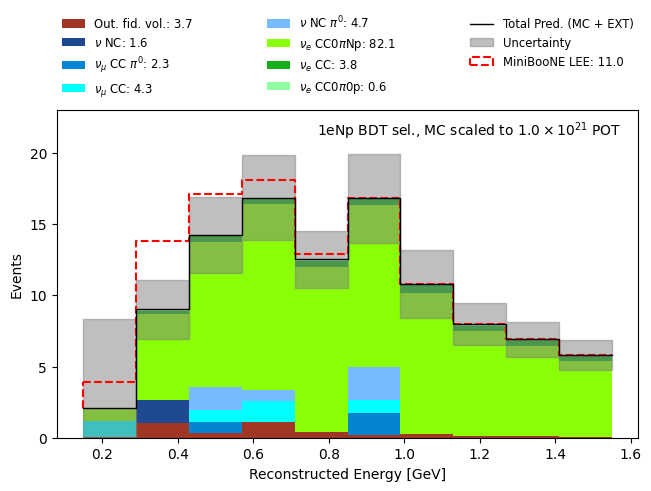

In [13]:
# We can also choose to rescale the data to any given POT.
# In that case, no data is shown.
ax = plotter.plot(
    category_column="category",
    include_multisim_errors=True,
    add_ext_error_floor=False,
    scale_to_pot=1e21,
)

## Loading Sideband Data

In order to include sideband constraints, we need to load the appropriate data, which is in this case the numu sideband. We will only load and plot the sideband data for now, the constrained predictions will be calculated later when we put the analysis together.

In [14]:
# First, we need to load the sideband data. We use the numu sideband.
RUN = ["3"]

rundata_numu, mc_weights_numu, data_pot_numu = load_runs(
    RUN,
    data="opendata_bnb",
    truth_filtered_sets=["nue", "drt"],
    loadshowervariables=False,
    loadsystematics=True,
    use_bdt=False,
    # set this to true to let the data loading function know that we are loading numu
    numupresel=True,
    loadnumuvariables=True,
    load_crt_vars=True,
    blinded=False,  # sideband needs to be unblinded to work
    enable_cache=True,
)

Loading run 3


In [15]:
# note that the sideband is binned by a different variable
sideband_binning = Binning.from_config("neutrino_energy", 14, (0.15, 1.55), "neutrino reconstructed energy [GeV]")
sideband_binning.label = "NUMU"  # a unique label to identify the channel later
sideband_generator = RunHistGenerator(
    rundata_numu,
    sideband_binning,
    data_pot=data_pot_numu,
    selection="NUMU",
    preselection="NUMU",
)
sideband_plotter = RunHistPlotter(sideband_generator)

/nashome/a/atrettin/PELEE/microfit/run_plotter.py:116: UserWarning: No signal category found in the MC hists. Not separating signal.
  warnings.warn("No signal category found in the MC hists. Not separating signal.")


(<AxesSubplot:xlabel='neutrino reconstructed energy [GeV]', ylabel='Events'>,
 None)

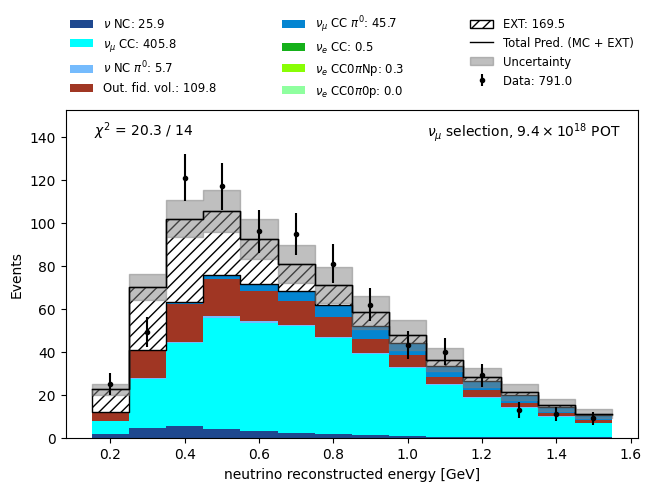

In [16]:
sideband_plotter.plot(
    include_multisim_errors=True,
    add_ext_error_floor=False,
    category_column="category",
    show_chi_square=True,
)

### Introducing parameters

To eventually run an analysis, we have to be able to generate histograms under differen hypotheses. This is done by replacing the object that calculates the histograms with one that can be configured with parameters. When the `RunHistGenerator` is initialized, we can pass a sub-class of the default `HistogramGenerator` (also defined in `histogram.py`).

For the case of the LEE analysis, we can use a pre-defined class called `SignalOverBackgroundGenerator`, which accepts a `signal_strength` parameter. It also accepts two additional keyword arguments for the `signal_query` and the `background_query`. Internally, this generator uses the queries to generate signal and background histograms separately. Then, it adds the signal multiplied by the `signal_strength` to the background.

In [17]:
from microfit.signal_generators import SignalOverBackgroundGenerator
from microfit.parameters import Parameter, ParameterSet

signal_parameters = ParameterSet(
    [
        Parameter("signal_strength", 1.0, bounds=(0, 10)),
    ]
)

signal_generator = RunHistGenerator(
    rundata,
    binning,
    data_pot=data_pot,
    # selection=selection,
    # preselection=preselection,
    # This overrides the default `HistogramGenerator` class, which just produces 
    # a histogram without any parametrization.
    mc_hist_generator_cls=SignalOverBackgroundGenerator,
    parameters=signal_parameters,
    signal_query="category == 111",
    background_query="category != 111",
)
signal_plotter = RunHistPlotter(signal_generator)

/nashome/a/atrettin/PELEE/microfit/histogram/binning.py:265: UserWarning: The 'labels' property is deprecated. Use 'channels' instead.
  "The 'labels' property is deprecated. Use 'channels' instead.",


(<AxesSubplot:xlabel='Reconstructed Energy [GeV]', ylabel='Events'>, None)

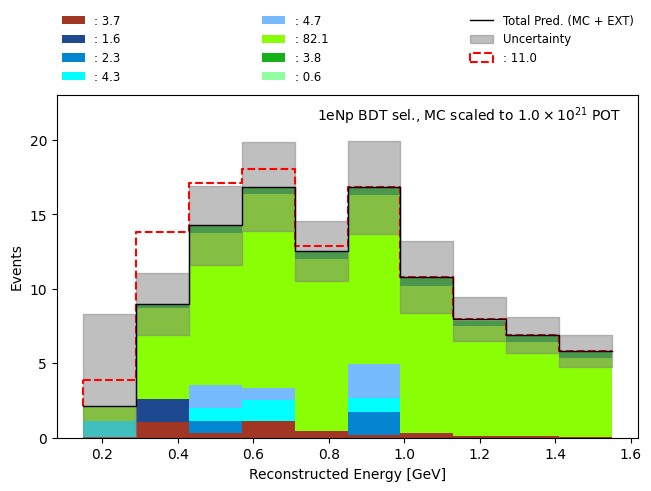

In [18]:
# The ParameterSet defines a set of parameters that may be used by several signal generators at once. 
signal_plotter.plot(include_multisim_errors=True, add_ext_error_floor=False, category_column="category", scale_to_pot=1e21)

### Consistency between the Signal over Background calculation and the standard calculation

The `SignalOverBackgroundGenerator` internally creates the signal and background histograms and adds them together. If this were done naively without taking the correlation between the systematics into account, this would lead to an incorrect covariance matrix. The correct covariance of the sum of two histograms, $A$ and $B$, is

$$ \text{Cov}(A+B, A+B) = \text{Cov}(A) + \text{Cov}(B) + \text{Cov}(A, B) + \text{Cov}(B, A)\;.$$

The `SignalOverBackgroundGenerator` is taking this into account when summing the signal and background, leading to the same covariance. 

In [19]:
signal_generator.parameters["signal_strength"].value = 1.0
total_prediction_sob_generator = signal_generator.get_total_prediction(include_multisim_errors=True)

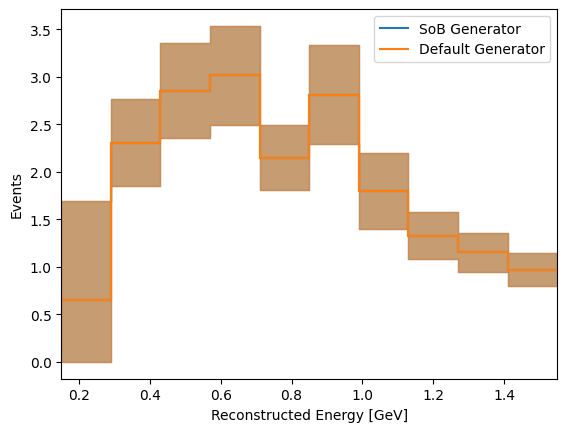

In [20]:
fig, ax = plt.subplots()
total_prediction_sob_generator.draw(ax=ax, label="SoB Generator", as_errorbars=False)
total_prediction.draw(ax=ax, label="Default Generator", as_errorbars=False)
ax.legend()
plt.show()

We can assert that the full covariance matrix is indeed close to within tight tolerance.

In [21]:
np.testing.assert_allclose(
    total_prediction_sob_generator.covariance_matrix,
    total_prediction.covariance_matrix,
)

#### Manipulating parameters

When manipulating parameters, be sure to alway set the _value_ and not replace the actual parameter object! This is necessary because parameters may be shared _by reference_ between different `RunHistGenerator` objects to synchronize parameters between signals.

In [22]:
signal_generator.parameters["signal_strength"].value = 5.0

(<AxesSubplot:xlabel='Reconstructed Energy [GeV]', ylabel='Events'>, None)

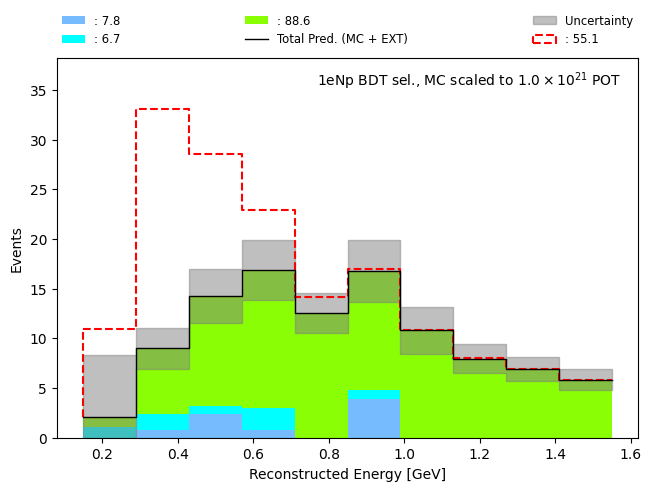

In [23]:
# The change in signal strength is reflected in the plot.
signal_plotter.plot(include_multisim_errors=True, add_ext_error_floor=False, category_column="paper_category", scale_to_pot=1e21)

### Parameter sharing

Parameters can be shared by reference between different signal generators.

In [24]:
second_binning = binning.copy()
second_binning.label = "ZPBDT"  # a unique label to identify the channel later
second_binning.set_selection("ZPBDT", "ZP")

second_signal_generator = RunHistGenerator(
    rundata,
    second_binning,
    data_pot=data_pot,
    # selection="ZPBDT",
    # preselection="ZP",
    mc_hist_generator_cls=SignalOverBackgroundGenerator,
    parameters=signal_parameters,
)
second_signal_plotter = RunHistPlotter(second_signal_generator)

(<AxesSubplot:xlabel='Reconstructed Energy [GeV]', ylabel='Events'>, None)

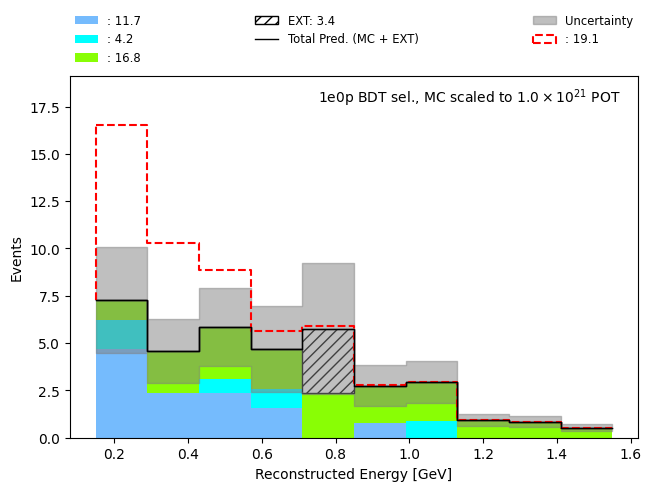

In [25]:
second_signal_plotter.plot(include_multisim_errors=True, add_ext_error_floor=False, category_column="paper_category", scale_to_pot=1e21)

In [26]:
# we can show that the actual parameter objects are the same
print(signal_generator.parameters is second_signal_generator.parameters)

True


(<AxesSubplot:xlabel='Reconstructed Energy [GeV]', ylabel='Events'>, None)

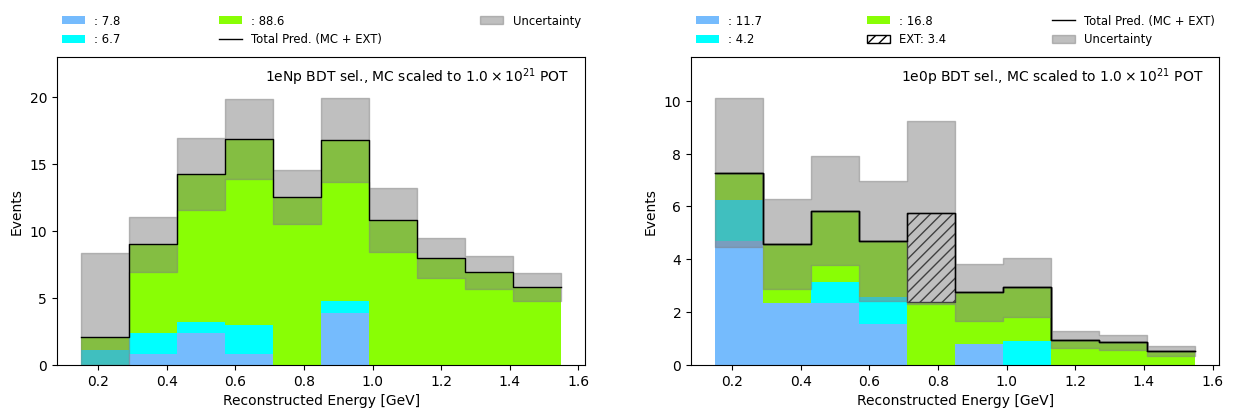

In [27]:
# When we set the parameter to zero in one, the signal disappears in both.
signal_generator.parameters["signal_strength"].value = 0.0
# make two axes side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
signal_plotter.plot(
    ax=ax1,
    include_multisim_errors=True,
    add_ext_error_floor=False,
    category_column="paper_category",
    scale_to_pot=1e21,
)
second_signal_plotter.plot(
    ax=ax2,
    include_multisim_errors=True,
    add_ext_error_floor=False,
    category_column="paper_category",
    scale_to_pot=1e21,
)

## Defining an Analysis

The `MultiBandAnalysis` class defined in `analysis.py` is a convenience class that defines an analysis with multiple signal bands. It can calculate the full multiband covariance matrix with and can calculate the chi-square between the data and the prediction. Any channel that has data can be used as a constraint channel, and any number of constraint channels are supported.

There are two ways to initialize an analysis:
* Passing a list of `RunHistGenerator` objects
* Passing a configuration dictionary from a TOML file

We will first define it from the `RunHistGenerator`s we have already set up above

In [28]:
from microfit.analysis import MultibandAnalysis

# At this point, the "label" properties that we have assigend to the binnings are used to
# identify the channels. The analysis generates a multi-channel histogram with the
# appropriate correlations between bins. Then, sideband constraints can be applied to
# the signal channels.
analysis = MultibandAnalysis(run_hist_generators=[sideband_generator, signal_generator, second_signal_generator], constraint_channels=["NUMU"], signal_channels=["NPBDT", "ZPBDT"])

In [29]:
# Channels are automatically aggregated over all the RunHistGenerators.
analysis.channels

['NUMU', 'NPBDT', 'ZPBDT']

In [30]:
analysis.signal_channels

['NPBDT', 'ZPBDT']

The analysis class internally combines the histograms produced by the different run hist generators into a multi-channel histogram. These multi-channel histograms keep track of the correlations between all the different channels.

/nashome/a/atrettin/PELEE/microfit/histogram/binning.py:265: UserWarning: The 'labels' property is deprecated. Use 'channels' instead.
  "The 'labels' property is deprecated. Use 'channels' instead.",


<AxesSubplot:xlabel='Global bin number', ylabel='Events'>

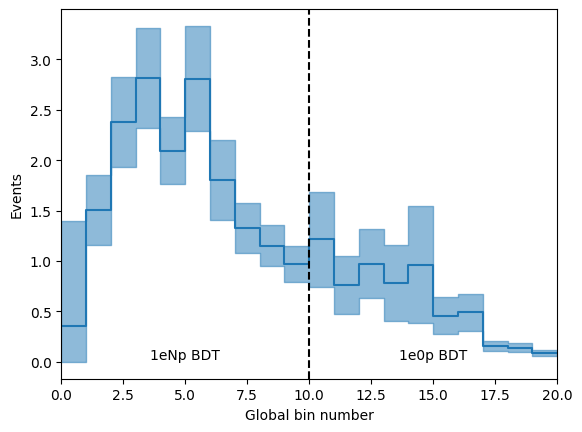

In [31]:
histogram_no_constraint = analysis.generate_multiband_histogram(
    include_multisim_errors=True
)
histogram_with_constraint = analysis.generate_multiband_histogram(
    include_multisim_errors=True, use_sideband=True
)

# This is a multi-channel histogram of the MC prediction *before* the application of the sideband constraint
histogram_no_constraint.draw()

<AxesSubplot:title={'center':'Correlation matrix'}>

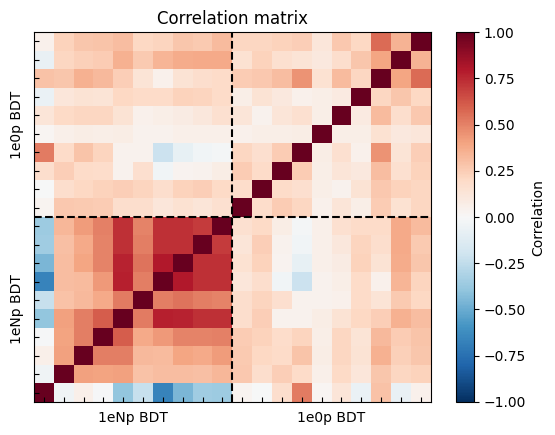

In [32]:
# The histogram contains the full covariance matrix between all channels.
histogram_no_constraint.draw_covariance_matrix()

<AxesSubplot:xlabel='Reconstructed Energy [GeV]', ylabel='Events'>

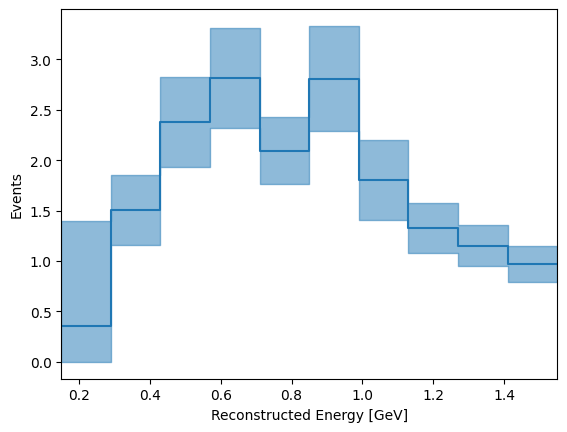

In [33]:
# We can extract channels from the multi-channel histogram by indices or by label.
histogram_no_constraint["NPBDT"].draw()

<AxesSubplot:title={'center':'Correlation matrix'}, xlabel='Reconstructed Energy [GeV]', ylabel='Reconstructed Energy [GeV]'>

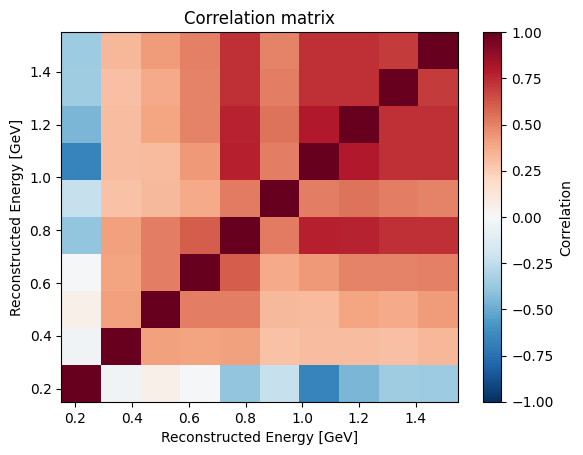

In [34]:
# We can extract channels from the multi-channel histogram by indices or by label.
histogram_no_constraint["NPBDT"].draw_covariance_matrix()

<AxesSubplot:title={'center':'Correlation matrix'}>

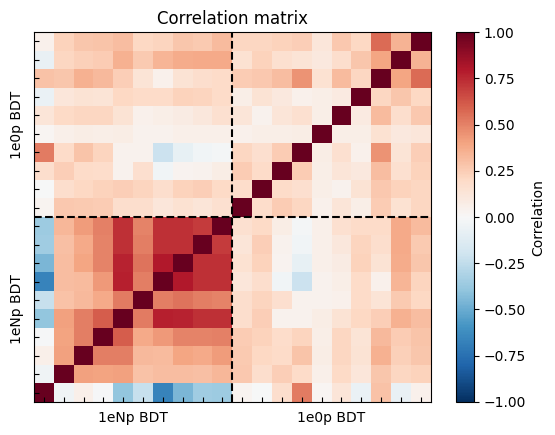

In [35]:
# Passing more than one key will extract the multi-channel histogram for the given channels.
histogram_no_constraint[["NPBDT", "ZPBDT"]].draw_covariance_matrix()

<AxesSubplot:title={'center':'Correlation matrix'}>

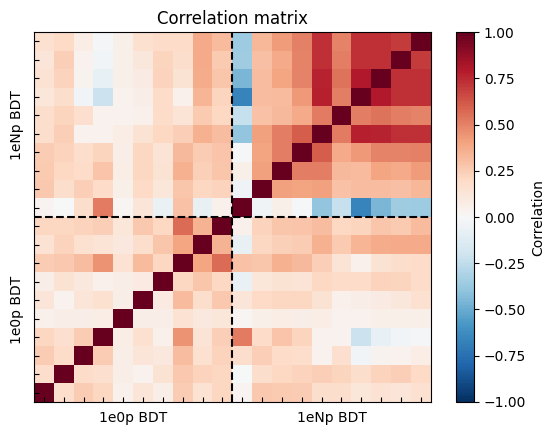

In [36]:
# We can re-arrange a multi-channel histogram easily by passing the keys in the order we want.
# The object internally takes care of moving the entries of the covariance matrix around.
histogram_no_constraint[["ZPBDT", "NPBDT"]].draw_covariance_matrix()

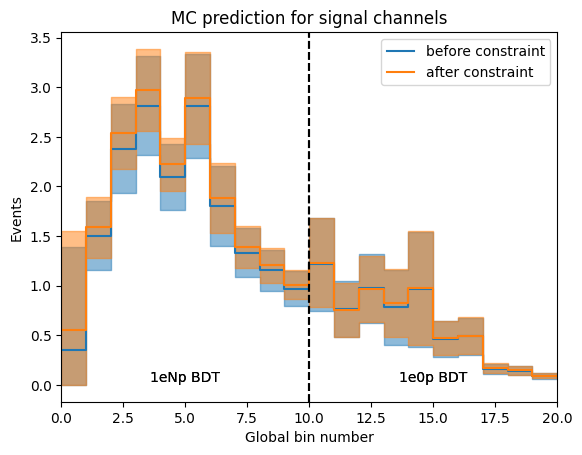

In [37]:
# Let's compare the signal histograms before and after the sideband constraint.
fig, ax = plt.subplots()
histogram_no_constraint[["NPBDT", "ZPBDT"]].draw(ax=ax, label="before constraint", as_errorbars=False)
histogram_with_constraint[["NPBDT", "ZPBDT"]].draw(ax=ax, label="after constraint", as_errorbars=False)
ax.legend()
ax.set_title("MC prediction for signal channels")
plt.show()

(<Figure size 1200x800 with 4 Axes>,
 array([[<AxesSubplot:ylabel='Events'>, <AxesSubplot:ylabel='Events'>],
        [<AxesSubplot:xlabel='Reconstructed Energy [GeV]', ylabel='Data/MC'>,
         <AxesSubplot:xlabel='Reconstructed Energy [GeV]', ylabel='Data/MC'>]],
       dtype=object))

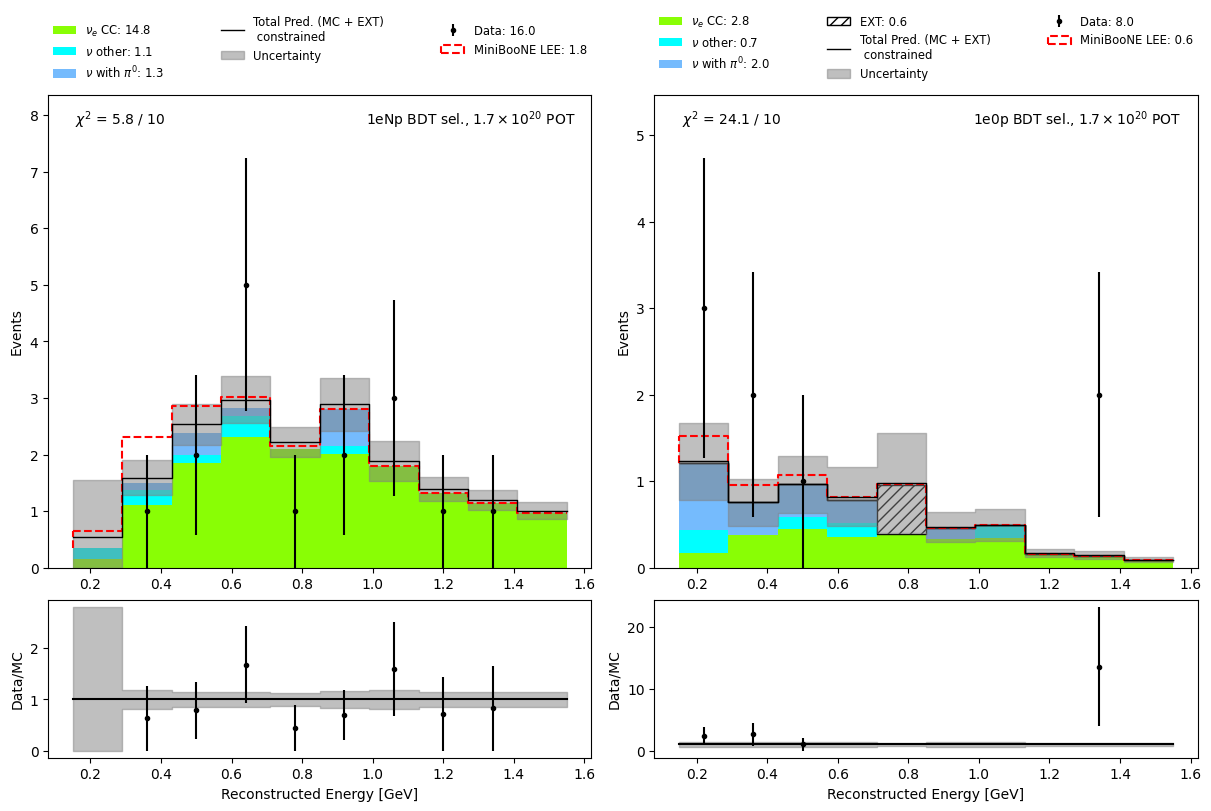

In [38]:
analysis.parameters["signal_strength"].value = 1.0

analysis.plot_signals(
    include_multisim_errors=True,
    add_ext_error_floor=False,
    category_column="paper_category",
    show_data_mc_ratio=True,
    show_chi_square=True,
    use_sideband=True
)

In [39]:
analysis.parameters

Parameters:
Name	Value	Unit	Bounds
-------------------------------
signal_strength	1		(0, 10)

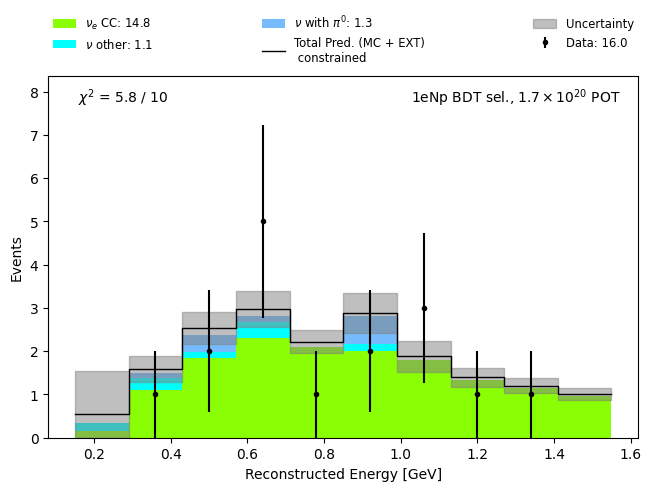

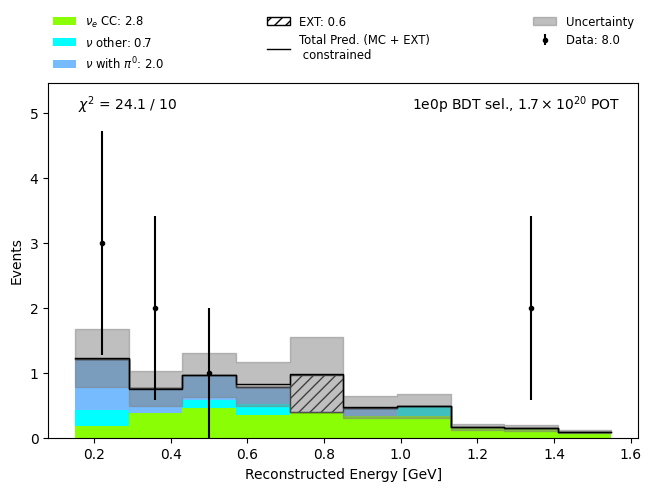

In [40]:
analysis.parameters["signal_strength"].value = 0.0
analysis.plot_signals(
    include_multisim_errors=True,
    add_ext_error_floor=False, category_column="paper_category",
    separate_figures=True,
    show_chi_square=True,
    use_sideband=True
)

(<Figure size 1200x500 with 2 Axes>,
 array([[<AxesSubplot:xlabel='Reconstructed Energy [GeV]', ylabel='Events'>,
         <AxesSubplot:xlabel='Reconstructed Energy [GeV]', ylabel='Events'>]],
       dtype=object))

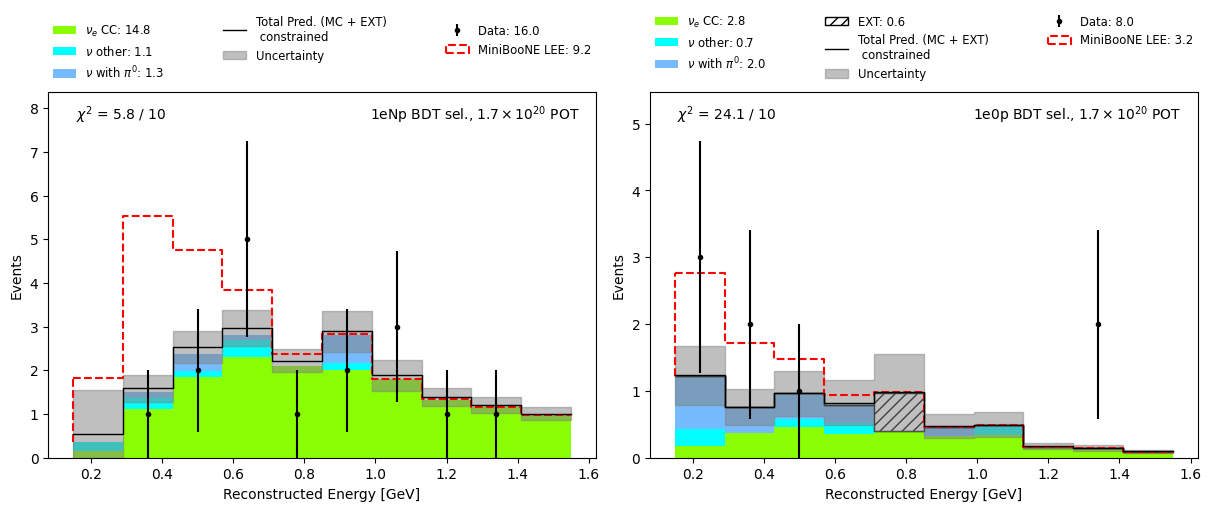

In [41]:
analysis.parameters["signal_strength"].value = 5.0
analysis.plot_signals(
    include_multisim_errors=True, add_ext_error_floor=False, category_column="paper_category", show_chi_square=True, use_sideband=True
)

### Alternative initialization via TOML file

We can initialize the analysis via a TOML file that defines the data to be loaded, the selections and binnings.

In [42]:
toml_string = """
# We can define any number of signal and constraint channels, which are identified
# by the selection name. The only limitation is that the channel must be defined 
# by one of the generators below and must be unique. Signal channels can be
# blinded or unblinded. Constraint channels must be unblinded.
# With blinded signal channels, we can still plot the MC prediction and 
# calculate sensitivities.

[channels]
signal_channels = ["NPBDT", "ZPBDT"]
constraint_channels = ["NUMUCRT"]

# Each expression in double brackets is an element in a list.
# We can define any number of generators in the same file.

[[generator]]

# The arguments in `load_runs` are all passed directly to the `load_runs` function.
[generator.load_runs]
run_numbers = ["3"]
data = "opendata_bnb"
truth_filtered_sets = ["nue", "drt"]
loadshowervariables = false
loadsystematics = true
use_bdt = false
loadnumuvariables = true
load_crt_vars = true
numupresel = true
enable_cache = true
blinded = false

# We can define any number of channels with different selections and binnings 
# for each generator. The `variable` is the name of the variable in the dataframe.
# The `selection` is the name of the selection defined in `selections.py`, and is
# also used to identify the channel. This also means that the selection must be unique
# across all generators.

[[generator.channel]]
variable = "neutrino_energy"
n_bins = 14
limits = [0.15, 1.55]
selection = "NUMUCRT"
preselection = "NUMU"
variable_tex = "Neutrino Reconstructed Energy (GeV)"

[[generator]]

# Here we use the `SignalOverBackgroundGenerator` class as described above. The analysis
# automatically searches the namespace for the class name and instantiates it.

mc_hist_generator_cls = "SignalOverBackgroundGenerator"

[generator.load_runs]
run_numbers = ["1"]
data = "bnb"
truth_filtered_sets = ["nue", "drt"]
loadpi0variables = true
loadshowervariables = true
loadrecoveryvars = true
loadsystematics = true
load_lee = true
enable_cache = true
blinded = false

# With this generator, we need to define the signal strength parameter
[[generator.parameter]]
name = "signal_strength"
value = 1.0
bounds = [0.0, 10.0]

# We also define two different channels with different selections. 
# We are using the same binning in both channels, but that is not required.
# We could also choose to plot different variables in the same selection, or
# use overlapping selections. In such cases where there are overlaps between
# the events in the bins of two channels, the statistical covariance will be
# calculated correctly.
[[generator.channel]]
variable = "reco_e"
n_bins = 10
limits = [0.15, 1.55]
selection = "NPBDT"
preselection = "NP"
variable_tex = "Reconstructed Energy (GeV)"

[[generator.channel]]
variable = "reco_e"
n_bins = 10
limits = [0.15, 1.55]
selection = "ZPBDT"
preselection = "ZP"
variable_tex = "Reconstructed Energy (GeV)"

"""
file_path = "example.toml"
# Write the TOML string to the file
with open(file_path, "w") as file:
    file.write(toml_string)

In [43]:
from microfit.analysis import MultibandAnalysis

analysis = MultibandAnalysis.from_toml(file_path)

Loading run 3


Loading run 1


In [44]:
analysis.channels

['NUMUCRT', 'NPBDT', 'ZPBDT']

In [45]:
analysis.parameters

Parameters:
Name	Value	Unit	Bounds
-------------------------------
signal_strength	1		(0, 10)

(<Figure size 1200x800 with 4 Axes>,
 array([[<AxesSubplot:ylabel='Events'>, <AxesSubplot:ylabel='Events'>],
        [<AxesSubplot:xlabel='Reconstructed Energy (GeV)', ylabel='Data/MC'>,
         <AxesSubplot:xlabel='Reconstructed Energy (GeV)', ylabel='Data/MC'>]],
       dtype=object))

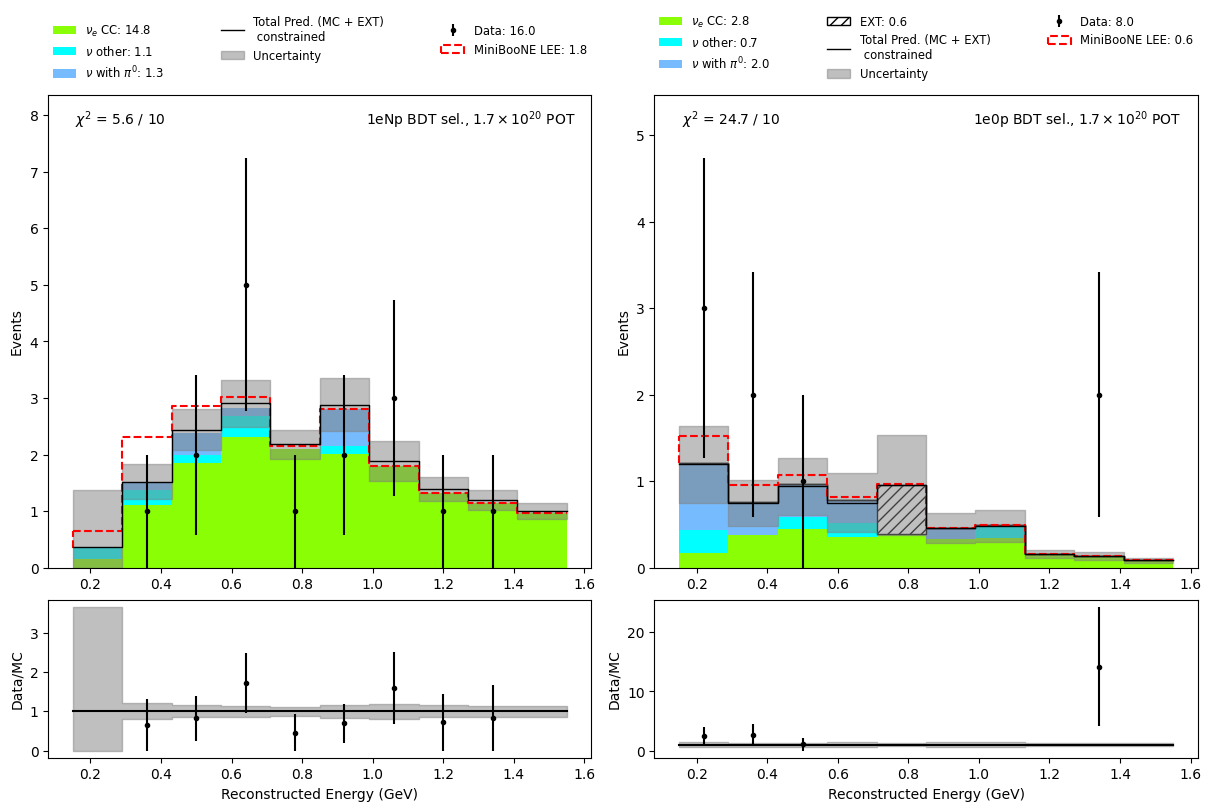

In [46]:
analysis.plot_signals(
    include_multisim_errors=True,
    add_ext_error_floor=False,
    category_column="paper_category",
    show_data_mc_ratio=True,
    show_chi_square=True,
    use_sideband=True
)

### Run the two-hypothesis test

The analysis defines a function that runs a two-hypothesis test. It will calculate the chi-square for the null hypothesis and the alternative hypothesis for a set number of trials.

In [47]:
# In the past, it used to be possible to scale to some given POT.
# This is no longer possible, because the analysis may use several different signal generators
# That each may have a different POT. It would not be possible to generally scale to a given POT
# in a physically sensible way. 

two_hypo_result = analysis.two_hypothesis_test(
    h0_params=ParameterSet([Parameter("signal_strength", 0.0)]),
    h1_params=ParameterSet([Parameter("signal_strength", 1.0)]),
    sensitivity_only=True,
    n_trials=1000,
)

Generating H0 histogram


Generating H1 histogram


Generating pseudo-experiments: 100%|██████████| 1000/1000 [00:12<00:00, 78.77it/s]


In [48]:
two_hypo_result.keys()

dict_keys(['ts_median_h1', 'median_pval', 'samples_h0', 'samples_h1', 'chi2_h0', 'pval_h0', 'chi2_h1', 'pval_h1'])

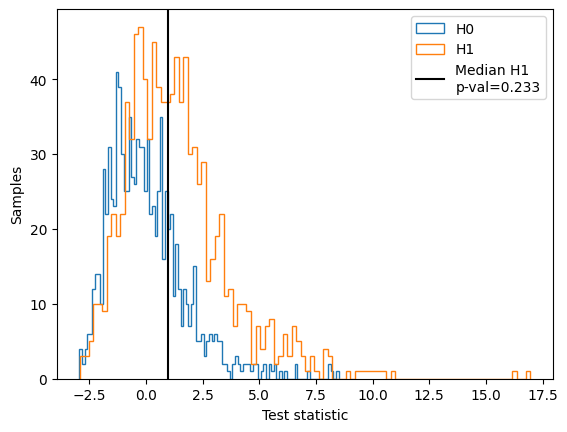

In [49]:
plt.hist(two_hypo_result["samples_h0"], bins=100, label="H0", histtype="step")
plt.hist(two_hypo_result["samples_h1"], bins=100, label="H1", histtype="step")
plt.axvline(two_hypo_result["ts_median_h1"], color="black", label=f"Median H1\np-val={two_hypo_result['median_pval']:.3f}")
plt.legend()
plt.xlabel("Test statistic")
plt.ylabel("Samples")
plt.show()

## Running a parameter fit with MINUIT

Besides the two-hypothesis test, we can also fit the parameters within their bounds by minimizing the chi-square test statistic using MINUIT.

Let's generate some pseudo-data by Poisson-fluctuating the prediction at our excess hypothesis and try to fit it back.

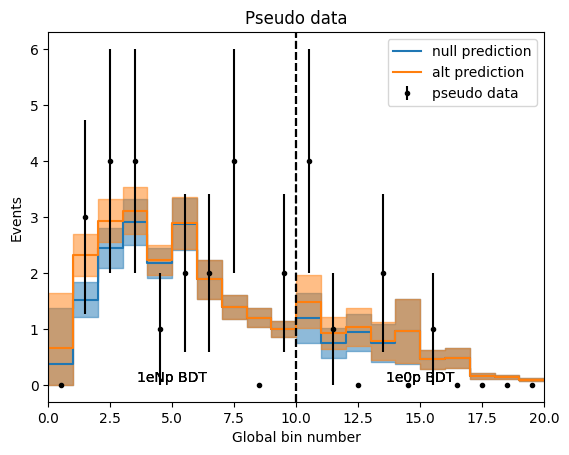

In [50]:
analysis.parameters["signal_strength"].value = 0.0
null_prediction = analysis.generate_multiband_histogram(include_multisim_errors=True, use_sideband=True)
analysis.parameters["signal_strength"].value = 1.0
alt_prediction = analysis.generate_multiband_histogram(include_multisim_errors=True, use_sideband=True)
pseudo_data = alt_prediction.fluctuate_poisson(seed=1)

fig, ax = plt.subplots()
null_prediction.draw(ax=ax, label="null prediction", as_errorbars=False)
alt_prediction.draw(ax=ax, label="alt prediction", as_errorbars=False)
pseudo_data.draw(ax=ax, label="pseudo data", as_errorbars=True, color="black")
ax.legend()
ax.set_title("Pseudo data")
plt.show()

In [51]:
analysis.parameters

Parameters:
Name	Value	Unit	Bounds
-------------------------------
signal_strength	1		(0, 10)

The analysis uses a Minuit object that is also returned after the fit alongside the best fit parameters.

In [52]:
analysis.parameters["signal_strength"].value = 5.0
best_chi2, bfp, m = analysis.fit_to_data(pseudo_data, return_migrad=True)
m

In [53]:
# These are the best fit parameters
bfp

Parameters:
Name	Value	Unit	Bounds
-------------------------------
signal_strength	2.7436037524		(0, 10)

In [54]:
m.minos()

return Minos error 

┌──────────┬───────────────────────┐
│          │    signal_strength    │
├──────────┼───────────┬───────────┤
│  Error   │   -1.6    │    2.3    │
│  Valid   │   True    │   True    │
│ At Limit │   False   │   False   │
│ Max FCN  │   False   │   False   │
│ New Min  │   False   │   False   │
└──────────┴───────────┴───────────┘

-0.122633  , 0.233093


Because we are using a Minuit object, we can use all the goodies that it provides out of the box, for instance to draw a likelihood scan with uncertainties.

/nashome/a/atrettin/miniforge3/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


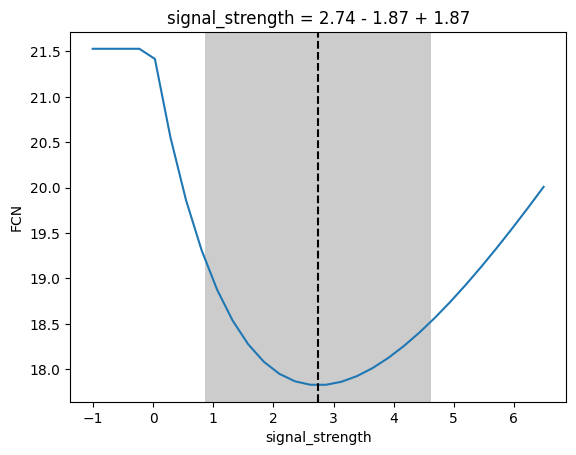

In [55]:
m.draw_mnprofile("signal_strength")
plt.show()

Text(0.5, 1.0, 'Pseudo data fit')

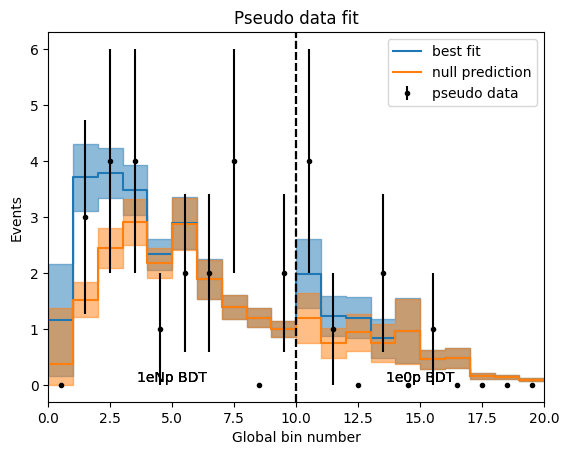

In [56]:
analysis.set_parameters(bfp)
best_fit_hist = analysis.generate_multiband_histogram(include_multisim_errors=True, use_sideband=True)

fig, ax = plt.subplots()
best_fit_hist.draw(ax=ax, label="best fit", as_errorbars=False)
null_prediction.draw(ax=ax, label="null prediction", as_errorbars=False)
# alt_prediction.draw(ax=ax, label="alt prediction", as_errorbars=False)
pseudo_data.draw(ax=ax, label="pseudo data", as_errorbars=True, color="k")
ax.legend()
ax.set_title("Pseudo data fit")


### Alternative fit method: Grid Scan

An alternative method to run a fit is to use a grid scan. While this might be slower and less accurate for a single fit, it can make use of caching to greatly speed up consecutive fits. This is useful for FC scans in particular that require many repeated fits over trials of pseudo-data.

In [57]:
fit_grid = {
    # It is important that the fit grid spans the full range of the parameter,
    # otherwise the fit could never reach those values.
    "signal_strength": np.linspace(0, 10, 50),
}
best_chi2, bfp = analysis.fit_to_data(pseudo_data, method="grid_scan", fit_grid=fit_grid)
print(bfp)
print(best_chi2)

Parameters:
Name	Value	Unit	Bounds
-------------------------------
signal_strength	2.6530612245		(0, 10)

17.82491763634288


### Running a 2D FC sensitivity scan

Finally, we can run a 2D sensitivity scan, where we get the classical, FC corrected confidence interval scanned over injected true points.
Producing these results takes a long time if we want them to be accurate, because we need to run n_trials x n_scan_points fits. For the purpose of this tutorial, we run the function with only 100 trials, which is of course not enough to make the plot reliably.

In [58]:
import numpy as np

scan_points = np.linspace(0, 5, 20)
fit_grid = {
    # This grid may (should) be denser than the scan points
    "signal_strength": np.linspace(0, 10, 50),
}
fc_scan_results = analysis.scan_asimov_fc_sensitivity(
    scan_points=scan_points,
    parameter_name="signal_strength",
    n_trials=100,
    fit_method="grid_scan",
    fit_grid=fit_grid,
)

Running FC scan over 20 points in signal_strength...


Scanning:  20%|██        | 4/20 [00:37<02:32,  9.54s/it]

Scanning: 100%|██████████| 20/20 [02:08<00:00,  6.41s/it]


Calculating Asimov sensitivity for 20 points...


The plotting function is implemented as a class method. This means that, if we store the `fc_scan_results` to a JSON file, we should be able to recover it and re-plot it later without having to initialize a new analysis. The `fc_scan_results` dictionary contains all the information that is needed to make the plot. 

(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot:xlabel='Measured signal strength', ylabel='True signal strength'>)

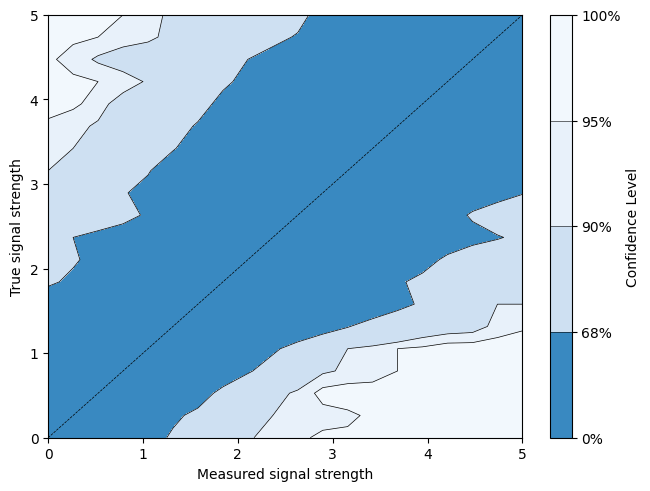

In [59]:
MultibandAnalysis.plot_fc_scan_results(fc_scan_results, parameter_tex="signal strength")